In [1]:
import numpy as np
import pickle
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

np.random.seed(3333)
torch.manual_seed(3333)

In [4]:
# Pytorch RNN axes:
# 1. The first axis is the sequence itself,
# 2. the second indexes instances in the mini-batch,
# 3. and the third indexes elements of the input.

# But we will put the batch axis in front (through the batch_first=True argument)

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.batch_size, self.num_layers, self.hidden_dim),
                torch.zeros(self.batch_size, self.num_layers, self.hidden_dim))

    def forward(self, input_X, lengths_X, max_length, temperature=1.0):
        # Forward pass through LSTM layer
        # shape of lstm_out: [batch_size, input_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both have shape (batch_size, num_layers, hidden_dim).
        packed_X = torch.nn.utils.rnn.pack_padded_sequence(input_X, lengths_X, batch_first=True)
        
        lstm_out, self.hidden = self.lstm(packed_X)
        
        unpacked_X, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, total_length=max_length)
        
        # Generate sequence predictions
        X_pred = self.linear(unpacked_X)
        
        # Apply nonlinearities
        X_softmax_1 = F.log_softmax(X_pred[:, :, :13] / temperature, dim=2)
        X_softmax_2 = F.log_softmax(X_pred[:, :, 13:] / temperature, dim=2)
        
        # Concatenate the two tensors along axis 2
        X_return = torch.cat((X_softmax_1, X_softmax_2), 2)
        
        return X_return

model = LSTM(input_dim=62, hidden_dim=512, batch_size=1, output_dim=62, num_layers=2)

In [6]:
## DATALOADER FOR MUSIC FILES
from torch.utils.data import DataLoader, Dataset

class MusicDataset(Dataset):
    def __init__(self, data_path, sequence_length=100):
        super(MusicDataset, self).__init__()
        self.sequence_length = sequence_length
        
        with open('processed_numpy/data.pkl', 'rb') as f:
            self.id_to_sheet = pickle.load(f)
            self.data = pickle.load(f)
        
        self.data = [x.astype(np.float32) for x in self.data]
        
        # pad all sequences to desired sequence length
        self.mask_lengths = []
        for i, x in enumerate(self.data):
            if len(x) < self.sequence_length + 1:
                s = x.shape
                self.data[i] = np.zeros((self.sequence_length + 1, s[1]), dtype=np.float32)
                self.data[i][:s[0], :] = x
                self.mask_lengths.append(s[0] - 1)
            else:
                self.mask_lengths.append(self.sequence_length)
                    
    def __len__(self):
        return sys.maxsize
        
    def __getitem__(self, index):
        data_index = np.random.randint(0, len(self.data))
        data_point = self.data[data_index][:, 130:]
        
        data_range = np.random.randint(0, len(data_point) - self.sequence_length)
        
        # return original sequence, target sequence, and original sequence lengths
        return (
            data_point[data_range:(data_range + self.sequence_length)],
            data_point[data_range + 1:(data_range + self.sequence_length + 1)],
            np.asarray(self.mask_lengths[data_index], dtype=np.float32)
        )

In [7]:
md = MusicDataset('processed_numpy/data.pkl', 100)

In [8]:
data_train_loader = DataLoader(md, batch_size=1, shuffle=False)

In [13]:
X = next(iter(data_train_loader))

In [40]:
X[0] = X[0].numpy()

In [48]:
X[0][0][5]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [51]:
X[0][0][:, 13:-1] = np.roll(X[0][0][:, 13:-1], 44)

In [52]:
X[0][0][5]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

In [14]:
# sequences should be sorted decreasing in length
def sort_batch(batch_data):
    batch_data[0] = batch_data[0][[x for _,x in sorted(zip(batch_data[2], range(0, 200)), reverse=True)]]
    batch_data[1] = batch_data[1][[x for _,x in sorted(zip(batch_data[2], range(0, 200)), reverse=True)]]
    batch_data[2] = batch_data[2][[x for _,x in sorted(zip(batch_data[2], range(0, 200)), reverse=True)]]
    
sort_batch(X)

In [12]:
def to_cuda(batch_data):
    return [x.cuda() for x in batch_data]
    
X = to_cuda(X)

In [276]:
Y = model(X[0], X[2], 100)

In [277]:
X[1][31][49]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')

In [278]:
Y.shape

torch.Size([32, 100, 62])

In [279]:
X[2]

tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100.,  60.,  59.], device='cuda:0')

In [280]:
def ce_loss(output, target, lenghts):
    logit_targets = output * target
    ce_1 = torch.mean(torch.sum(-torch.sum(logit_targets[:, :, :13], dim=2), dim=1) / lenghts)
    ce_2 = torch.mean(torch.sum(-torch.sum(logit_targets[:, :, 13:], dim=2), dim=1) / lenghts)
    return ce_1 + ce_2

In [327]:
ce_loss(Y, X[1], X[2])

tensor(0.6997, device='cuda:0', grad_fn=<AddBackward0>)

In [286]:
## TRAIN PROCEDURE
learning_rate = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

for batch_idx, batch_data in enumerate(data_train_loader):
    # zero grad model
    optimiser.zero_grad()
    
    # re-init hidden states
    model.hidden = model.init_hidden()
    
    sort_batch(batch_data)
    batch_data = to_cuda(batch_data)
    Y_output = model(batch_data[0], batch_data[2], 100)
    Y_target = batch_data[1]
    Y_lenghts = batch_data[2]
    
    loss = ce_loss(Y_output, Y_target, Y_lenghts)
    
    loss.backward()
    optimiser.step()
    
    if batch_idx % 50 == 0:
        print("Epoch ", batch_idx, "MSE: ", loss.item())

Epoch  0 MSE:  6.45391321182251
Epoch  50 MSE:  4.432456016540527
Epoch  100 MSE:  4.166339874267578
Epoch  150 MSE:  3.4746432304382324
Epoch  200 MSE:  2.928406000137329
Epoch  250 MSE:  2.2210330963134766
Epoch  300 MSE:  2.060547351837158
Epoch  350 MSE:  1.8461823463439941
Epoch  400 MSE:  1.8069108724594116
Epoch  450 MSE:  1.568809151649475
Epoch  500 MSE:  1.7201910018920898
Epoch  550 MSE:  1.6085624694824219
Epoch  600 MSE:  1.5100370645523071
Epoch  650 MSE:  1.7032045125961304
Epoch  700 MSE:  1.515383243560791
Epoch  750 MSE:  1.5181396007537842
Epoch  800 MSE:  1.407153844833374
Epoch  850 MSE:  1.5526185035705566
Epoch  900 MSE:  1.481121301651001
Epoch  950 MSE:  1.4455305337905884
Epoch  1000 MSE:  1.3509211540222168
Epoch  1050 MSE:  1.576219081878662
Epoch  1100 MSE:  1.567812442779541
Epoch  1150 MSE:  1.4649074077606201
Epoch  1200 MSE:  1.4041048288345337
Epoch  1250 MSE:  1.3846971988677979
Epoch  1300 MSE:  1.4110180139541626
Epoch  1350 MSE:  1.4043363332748413

KeyboardInterrupt: 

In [15]:
sort_batch(X)
#X = to_cuda(X)
Y = model(X[0], X[2], 100)

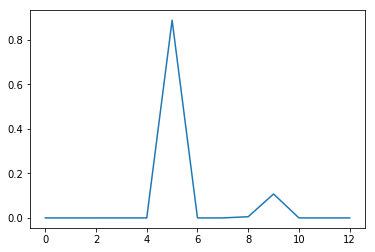

In [47]:
plt.plot(np.exp(Y[0][10][:13].cpu().detach().numpy()))

In [343]:
def sample_from_logits(input_sequence, length_sequence, max_length, temperature=1.0):
    return np.random.sample(model.forward(input_sequence, length_sequence, max_length, temperature))

In [344]:
sample_from_logits(X[0], X[2], 100, 0.1)

TypeError: 'Tensor' object does not support indexing

In [5]:
model.load_state_dict(torch.load('chord_rhythm_lstm/test/epoch_220000.model'))

In [3]:
with open('processed_sheets_numpy/data.pkl', 'rb') as f:
    id_to_sheet = pickle.load(f)
    data = pickle.load(f)

In [13]:
found = False
for i, d in enumerate(data):
    x = d[:, 130:143]
    for k in range(len(x)):
        if np.argmax(x[k]) == 6:
            print(i)
            print(id_to_sheet[i])
            found = True
            break
    if found:
        break

15
Kohlman - CRY.json
